# 12 Types of People
#### A Tour of Unstructured Data

 
I scraped the profiles of several thousand users on a popular website. Among the data on each profile is their favorite books, movies, TV shows, and even food. But this data is hard to make sense of; it's just a list of words.

Using some natural language processing, however, we can tame this data and discover some interesting insights.

In [1]:
import pandas as pd

from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation, digits

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import recall_score, accuracy_score

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# I've pre-wrangled and saved the data, but we'll still need to do a bit more work

data = pd.read_csv('favorites_data.csv')
del data['Unnamed: 0']

# Dataframe info
print('Shape:',data.shape)
print('Columns:', data.columns)

# Sample entries
data.sample(5)

Shape: (7116, 2)
Columns: Index(['favorites', 'length'], dtype='object')


,favorites,length
1763,"BOOKS-Sleeping Arrangements, The Great Gatspy,...",652
3157,*No time for pleasure reading these days. Micr...,371
4716,My TV/Movie Heroes include:* Red Reddington fr...,320
5200,"Fav books- most of Melody AnneMovies- so many,...",473
6731,"Books:(So far what I have read, or read Most o...",440


In [3]:
for i in punctuation:
    data['favorites'] = data['favorites'].str.replace(i, ' ')
    
data['favorites'] = data['favorites'].str.lower()

data = data[data.length > 2]

data.shape

(7116, 2)

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(max_df=.15, min_df=2)

tf.fit(data.favorites)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.15, max_features=None, min_df=2,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [5]:
def text_process(text, tf_stop_words):
    
    # Tfidf stopwords
    cleaned = [word for word in text.split() if word not in tf_stop_words]
    
    # NLTK stopwords
    cleaned = [word for word in cleaned if word not in stopwords.words('english')]
    
    cleaned = [word for word in cleaned if len(word) > 1]
    
    return cleaned


data['favorites'] = data['favorites'].apply(text_process, tf_stop_words=tf.stop_words_)

In [6]:
data['favorites'].sample(5)

6509    [enjoy, military, history, literature, current...
5836    [filme, serien, series, homeland, hannibal, tr...
26      [many, hard, list, reader, whole, life, raised...
4627    [lot, gym, interest, go, fried, foods, want, g...
484     [regular, chick, flicks, note, book, great, ga...
Name: favorites, dtype: object

In [7]:
things_liked = list(data['favorites'])

# Expand list of lists
everything_liked = [item for user in things_liked for item in user]

results = Counter(everything_liked)
results.most_common(40)

[('things', 1250),
 ('big', 1164),
 ('one', 1152),
 ('book', 1129),
 ('many', 1128),
 ('lot', 1102),
 ('enjoy', 1100),
 ('series', 1092),
 ('black', 1046),
 ('pretty', 1046),
 ('everything', 1046),
 ('reading', 1045),
 ('movie', 1032),
 ('dead', 1003),
 ('thrones', 992),
 ('life', 988),
 ('american', 961),
 ('fiction', 959),
 ('house', 938),
 ('always', 933),
 ('show', 924),
 ('horror', 908),
 ('listen', 891),
 ('list', 857),
 ('eat', 817),
 ('country', 812),
 ('get', 795),
 ('etc', 792),
 ('bad', 775),
 ('harry', 771),
 ('favorites', 737),
 ('star', 730),
 ('go', 714),
 ('potter', 711),
 ('know', 704),
 ('stuff', 694),
 ('sushi', 688),
 ('old', 657),
 ('walking', 650),
 ('try', 641)]

This a bag-of-words approach so it requires some pop-culture domain knowledge to interpret. Here's what I notice in the list:

1. Rock music
2. Game of Thrones
3. The Walking Dead
4. Harry Potter
5. Sushi
6. Italian food
7. Pop music
8. Thai food
9. Mexican food
10. Hip-hop music
 
Things that "might" be mentioned (in no particular order):
1. This American Life
2. Black Mirror
3. Orange is the New Black
4. Clockwork Orange
5. American Horror Story
6. House, M.D.
7. House music
8. Star Wars
9. Star Trek
10. Family Guy
11. Modern Family

These are my educated guesses. People might be huge fans of *Little House on the Prairie*, but I doubt it.

# Creating the DataFrame
This is where the real magic happens. I iterate over each word used, then (if necessary) create a new column with that word and assign it a value of 1. We can then look at correlations and create a simple recommender system.

I saved the results to a csv, then put the code in a function. I only needed to run it once.

In [8]:
def favorites_df(mentions=20, save=True):
    df = pd.DataFrame()

    for i in range(len(data)):

        for j in things_liked[i]:
            if results[j] >= mentions: #set a threshold
                df.at[i, j] = 1

    df.fillna(0, inplace=True)
    
    if save == True:
        df.to_csv('favorites_processed.csv', encoding='utf-8')
    
    return df

In [9]:
# Retrieving the csv I saved with the previous function
df = pd.read_csv('favorites_processed.csv')
del df['Unnamed: 0'] # import bug

df.head(3)

,broken,social,get,scissorhands,italo,calvino,dorothy,parker,forster,seen,...,mccaffrey,wwe,mobile,sevendust,whovian,viking,♪♫,msi,battlefield,1993
0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
def corrs(corr_item=df['thrones'], df=df):
    '''
    Finds correlated words, then sorts by absolute value to account for
    strong negative correlations.
    '''
    cor = df.select_dtypes(include=[np.number]).corrwith(corr_item)
    df = pd.DataFrame(cor.sort_values(ascending=False),columns=['corr'])
    df['absol'] = np.abs(df['corr'])
    return df[df.absol < 1].sort_values('absol', ascending=False)['corr']         

In [11]:
# Titles that were ambiguous from our top results, or might
# otherwise be hard to find. Not perfect, but works well enough.

df['always_sunny'] = np.where((df.always == 1) & (df.sunny == 1), 1, 0)
df['american_dad'] = np.where((df.american == 1) & (df.dad == 1) & (df.horror == 0), 1, 0)
df['american_horror_story'] = np.where((df.american == 1) & (df.dad == 0) & (df.horror == 1), 1, 0)
df['big_bang_theory'] = np.where((df.bang == 1) & (df.theory == 1), 1, 0)
df['black_mirror'] = np.where((df.black == 1) & (df.mirror == 1), 1, 0)
df['clockwork_orange'] = np.where((df.clockwork == 1) & (df.orange == 1), 1, 0)

# People love to point out that they hate country music.
df['country'] = np.where((df.country == 1) & (df['except'] == 0), 1, 0) 

df['crazy_ex_girlfriend'] = np.where((df.crazy == 1) & (df.ex == 1), 1, 0)
df['criminal_minds'] = np.where((df.criminal == 1) & (df.minds == 1), 1, 0)
df['family_guy'] = np.where((df.family == 1) & (df.guy == 1), 1, 0)
df['final_fantasy'] = np.where((df.final == 1) & (df.fantasy == 1), 1, 0)
df['lord_of_the_rings'] = np.where((df.lord == 1) & (df.rings == 1), 1, 0)
df['modern_family'] = np.where((df.modern == 1) & (df.family == 1), 1, 0)
df['name_of_the_wind'] = np.where((df.wind == 1) & (df.name == 1), 1, 0) # My favorite book!
df['orange_is_the_new_black'] = np.where((df.black == 1) & (df.orange == 1), 1, 0)
df['pans_labyrinth'] = np.where((df.pan == 1) & (df.labyrinth == 1), 1, 0)
df['princess_bride'] = np.where((df.princess == 1) & (df.bride == 1), 1, 0)
df['south_park'] = np.where((df.south == 1) & (df.park == 1), 1, 0)
df['star_trek'] = np.where((df.star == 1) & (df.trek == 1), 1, 0) # Really, "trek" would be enough.
df['star_wars'] = np.where((df.star == 1) & (df.wars == 1), 1, 0)
df['the_office'] = np.where((df.office == 1) & (df.space == 0), 1, 0)
df['this_american_life'] = np.where((df.american == 1) & (df.life == 1), 1, 0)
df['whose_line'] = np.where((df.whose == 1) & (df.line == 1), 1, 0)
df['fight_club'] = np.where((df.fight == 1) & (df.club == 1), 1, 0)
df['game_of_thrones'] = df.thrones

# Just tidying these up because they'll appear in the next cells otherwise
del df['thrones']
del df['fight']
del df['club']

# One of my favorite shows, and a huge pain to search for!
df['lost_tv_show'] = np.where((df.lost == 1) & (df.translation == 0) &\
                              (df.boys == 0) & (df.paradise == 0) &\
                              (df.getting == 0) & (df.world == 0) &\
                              (df.souls == 0) & (df.children == 0) &\
                              (df.girl == 0), 1, 0)


We can look at similarity in two ways; either by calculating correlations or cosine difference. Most recommender systems I've seen prefer cosine difference because it handles missing ratings more elegantly.

In [12]:
corrs(df.inception).head(10)

matrix          0.131429
interstellar    0.126217
memento         0.111756
500             0.104910
linkin          0.102768
fight_club      0.100888
knight          0.099501
julian          0.089933
assassin        0.088461
hunting         0.087742
Name: corr, dtype: float64

In [13]:
from scipy.spatial.distance import cosine

def get_cosine(title):
    cos = {}
    for i in df.columns:
        cos[i] = 1 - cosine(df[title], df[i])

    cos = pd.DataFrame([cos]).T.sort_values(0, ascending=False)

    return cos[(cos[0] < 1)].head(10)

get_cosine('inception')

,0
matrix,0.144138
interstellar,0.135185
memento,0.121933
fight_club,0.119808
game_of_thrones,0.118384
500,0.114708
knight,0.112956
linkin,0.111694
potter,0.109619
men,0.106430


The difference between these methods is actually minimal. People who like Inception also tend to like:
- The Matrix
- Interstellar
- Memento
- 500 Days of Summer
- Linkin Park
- The Dark Knight
- Fight Club
- Harry Potter
- Game of Thrones

# Clusters
What if there are certain "types" of people in terms of personal tastes? A cluster analysis could uncover this.

In [14]:
# Create a new dataframe. We need to increase the popularity
# threshold to 50 to reduce dimensionality.

df_popular = favorites_df(mentions=50, save=False)

In [15]:
df_popular.shape

(7083, 1476)

There's no avoiding it: We'll have to reduce the number of dimensions in order to perform a cluster analysis. Let's see if we can find a point of diminishing returns.

In [16]:
from sklearn.decomposition import PCA

variance_dict = {}

for i in range(1,1100,100):
    pca = PCA(n_components=i, whiten=True).fit(df_popular)
    variance_dict[i] = sum(pca.explained_variance_ratio_)

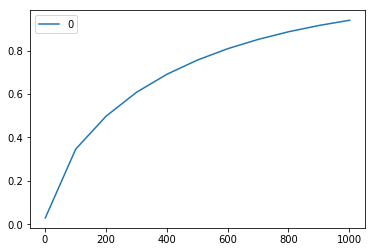

In [17]:
vdf = pd.DataFrame([variance_dict]).T.plot()

There's an elbow at approximately 100, but that's still too many features for this data set.

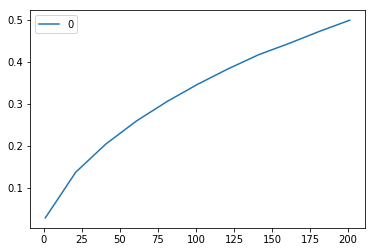

In [18]:
variance_dict = {}

for i in range(1,210,20):
    pca = PCA(n_components=i, whiten=True).fit(df_popular)
    variance_dict[i] = sum(pca.explained_variance_ratio_)
    
pd.DataFrame([variance_dict]).T.plot()

20 appears to be another good option. However, after much trial and error, I discovered that it's most effective to capture about 10% of the variance with only 10 features. It makes our clustering decisions much easier.

In [19]:
pca = PCA(n_components=10, whiten=True).fit(df_popular)

dframe = pca.transform(df_popular)

print('PCA explained variance:', sum(pca.explained_variance_ratio_))
print('Shape:', dframe.shape)

PCA explained variance: 0.09000227274426262
Shape: (7083, 10)


We're only catching a tiny fraction of the variance, but it'll have to do.

Next question: How many clusters should we have?

In [20]:
# Inertia measures the average distance to the nearest centroid.
# We want it to be low, but adding more clusters is always going
# to reduce it. So we need to find a point of diminishing returns.

kdict = {}

for i in range(2,20):
    clf = KMeans(n_clusters=i)
    clf.fit(dframe)
    kdict[i] = clf.inertia_

kframe = pd.DataFrame([kdict]).T
kframe.columns = ['inertia']

# Calculate the improvement as a percentage
kframe['improvement'] = (kframe['inertia'].shift(1) - kframe['inertia'])/kframe['inertia'].shift(1)

kframe

,inertia,improvement
2,65533.719015,NaN
3,60678.536845,0.074087
4,56775.822920,0.064318
5,52999.465204,0.066513
6,50154.666485,0.053676
7,47747.634201,0.047992
8,45663.922456,0.043640
9,43839.362268,0.039956
10,42184.491507,0.037749
11,40943.425373,0.029420


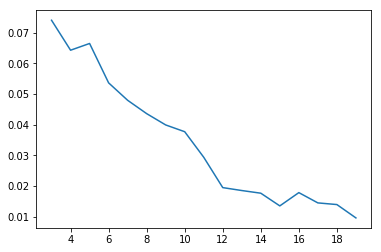

In [21]:
kframe.improvement.plot()

12 appears to be a good number of clusters. We can also run a silhouette analysis to confirm this.

In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

for i in range(2,16):
    cl = KMeans(n_clusters=i, random_state=42).fit(df_popular)
    print(i, silhouette_score(df_popular, cl.labels_))

2 0.2141392720614083
3 0.14638383982559514
4 0.0860740576564094
5 0.10042117821801128
6 0.07777266361374029
7 0.10583114110534803
8 0.056456553136197136
9 0.05911581401568933
10 0.030487760350091087
11 0.02294034015987766
12 0.07169292841440145
13 0.042319684641182395
14 0.006826721875498327
15 0.07012991500912334


When the data isn't in obvious clusters, a silhouette score is usually going to favor just 2 clusters. But that's no fun! 5, 7, 12, and 15 all look like good options, so let's stick with 12.

In [23]:
clf = KMeans(n_clusters=12)
clf.fit(df_popular)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [24]:
df_popular['cluster'] = clf.labels_ + 1 # start counting at 1

In [25]:
groups = df_popular.groupby('cluster').mean()

groups = groups[(groups > .1)]
groups.dropna(how='all', axis=1, inplace=True)

In [26]:
groups = groups.dropna(how='all',axis=1).fillna(0)

In [28]:
for i in range(len(groups)):
    print('Cluster', str(i+1))
    for j in groups.columns:
        if groups.iloc[i][j] > .2:
            print(j, end=', ')
    print()
    print()

Cluster 1
get, moment, south, secret, crime, 1984, life, think, series, house, black, family, guy, american, dad, arrested, development, scrubs, breaking, bad, anatomy, walking, dead, upon, metal, horror, things, would, world, night, heart, two, la, soul, history, lot, art, people, john, murder, school, last, pretty, full, different, ice, les, wild, alchemist, little, daily, true, case, modern, men, point, thrones, hunger, great, whole, kill, justice, castle, jane, fire, show, tonight, oliver, harry, potter, songs, club, atlas, perks, seinfeld, mad, hannibal, dexter, burgers, park, story, place, shakespeare, wind, king, pride, room, stewart, angel, away, adams, parks, five, phantom, sherlock, holmes, empire, archer, adventures, supernatural, death, color, tale, jimmy, alice, billy, chris, garden, bob, sense, prince, lord, rings, blue, gone, adventure, ted, attack, count, monte, detective, heroes, frank, blacklist, scandal, dragon, meet, half, wonderland, west, 30, blood, lie, remember,

# Machine Learning Your Tastes

I like Game of Thrones, Breaking Bad, Lost, Ferris Bueller, and The Walking Dead. Would I like Margaret Atwood?

In [29]:
my_tastes = {'game_of_thrones': 1, 'breaking': 1, 'bad': 1, 'walking': 1, 'dead': 1,
             'lost_tv_show': 1, 'name_of_the_wind': 1, 'ferris': 1, 'bueller': 1}

df = df.append(my_tastes, ignore_index=True).fillna(0)

In [30]:
x = df.copy()
y = x.pop('atwood')

del x['handmaid']
del x['margaret']
del x['tale']
del x['heart']
del x['goes']
del x['last']
del x['year']

In [36]:
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier

# Pre-tested different parameters
clf = XGBClassifier()
params = {'max_depth': [3],
         'reg_lambda': [1.0],
         'n_estimators': [50, 100, 200]}
grid = GridSearchCV(clf, param_grid=params, cv=3, scoring='roc_auc').fit(x, y)
clf = grid.best_estimator_

cv = cross_val_score(clf, x, y, cv=4, scoring='roc_auc')

print(clf, '\n')
print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1.0,
       scale_pos_weight=1, seed=0, silent=True, subsample=1) 

Mean score: 0.8247904567360391
Std Dev:    0.05424798749327766


In [37]:
# What predicts liking Atwood, anyway?

atwood = pd.DataFrame([df.columns, clf.feature_importances_, ]).transpose()
atwood.columns = ['feature', 'importance']

atwood.sort_values('importance', ascending=False).head(10)

,feature,importance
1761,eggers,0.0493562
3482,stan,0.0429185
42,reading,0.0407725
5028,gershwin,0.0300429
128,things,0.027897
5633,usa,0.027897
1760,dave,0.0214592
601,great,0.0214592
3300,gang,0.0214592
1109,mood,0.0214592


So, would I like Margaret Atwood?

In [67]:
preds = clf.predict_proba(x)[:, 1]

In [70]:
# z-score to compare me to other users
preds[-1] - preds.mean() / preds.std()

-0.28276134

Apparently Margaret Atwood isn't for me. I probably would like her though -- I just didn't give the model enough to judge me on!